<a href="https://colab.research.google.com/github/emilyberlinghoff/DS3000/blob/main/Homework%204/251287809_H04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


# 1. Wisconsin Breast Cancer Dataset

In this assignment, you will use a modified version of the well-known Wisconsin Breast Cancer dataset. We want to predict if a patient has a malignant or benign tumour. The features in the dataset are described below:


**Cl.thickness**:	Clump Thickness

**Cell.size**:	Uniformity of Cell Size

**Cell.shape**:	Uniformity of Cell Shape

**Marg.adhesion**:	Marginal Adhesion

**Epith.c.size**:	Single Epithelial Cell Size

**Bare.nuclei**:	Bare Nuclei

**Bl.cromatin**:	Bland Chromatin

**Normal.nucleoli**:	Normal Nucleoli

**Mitoses**:	Mitoses

**Age**: Age

**Class**: 1 if malignant, 0 if benign

In [8]:
# Package import
import numpy as np

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Data management imports
import pandas as pd
import polars as pl

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
# Uncomment the line below if you are using Google colab
# !gdown https://drive.google.com/uc?id=12Y-PdpmPLInGGBvFAn_G3eCfXrRETvuF

1. Read the CSV file using Polars and store it. Use "null_values=['NA']". Show summary statistics for the dataset. What is the baseline accuracy for a model?

In [17]:
# Load the dataset using Polars and treat 'NA' as null values
df_pl = pl.read_csv("Breast Cancer Data.csv", null_values=['NA'])

# Display summary statistics
print("Summary Statistics:\n", df_pl.describe())

# Check class distribution for baseline accuracy
class_counts = df_pl['Class'].value_counts()

# Print column names for debugging
print("\nColumn Names in value_counts():", class_counts.columns)

# Extract actual column names dynamically
class_col, count_col = class_counts.columns

# Sort to find the majority class (most frequent)
sorted_counts = class_counts.sort(count_col, descending=True)

# Extract the majority class and compute baseline accuracy
majority_class = sorted_counts[class_col][0]  # Extracts first row's class
baseline_accuracy = sorted_counts[count_col][0] / sorted_counts[count_col].sum()

print("\nClass Distribution:\n", class_counts)
print(f"\nBaseline Accuracy (predicting majority class '{majority_class}'): {baseline_accuracy:.4f}")

Summary Statistics:
 shape: (9, 12)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬──────────┬───────────┐
│ statistic  ┆ Cl.thickn ┆ Cell.size ┆ Cell.shap ┆ … ┆ Normal.nu ┆ Mitoses  ┆ Class    ┆ Age       │
│ ---        ┆ ess       ┆ ---       ┆ e         ┆   ┆ cleoli    ┆ ---      ┆ ---      ┆ ---       │
│ str        ┆ ---       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ f64      ┆ f64      ┆ f64       │
│            ┆ f64       ┆           ┆ f64       ┆   ┆ f64       ┆          ┆          ┆           │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪══════════╪═══════════╡
│ count      ┆ 696.0     ┆ 694.0     ┆ 694.0     ┆ … ┆ 699.0     ┆ 699.0    ┆ 699.0    ┆ 699.0     │
│ null_count ┆ 3.0       ┆ 5.0       ┆ 5.0       ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ 0.0       │
│ mean       ┆ 4.426724  ┆ 3.136888  ┆ 3.208934  ┆ … ┆ 2.866953  ┆ 1.569385 ┆ 0.344778 ┆ 50.100143 │
│ std        ┆ 2.815748  ┆ 3.053632  ┆ 2.973356  ┆ … ┆ 

Baseline accuray is 0.6552 (65.52%)

2. Assume that we are only interested in studying people aged 100 or less. Remove anyone with ages larger than that. (Note that this slightly changes your baseline accuracy.)

In [14]:
# Filter out individuals older than 100
df_filtered = df_pl.filter(df_pl["Age"] <= 100)

# Display new dataset summary
print("Updated Summary Statistics:\n", df_filtered.describe())

# Recalculate class distribution and baseline accuracy
class_counts_filtered = df_filtered['Class'].value_counts()

# Extract column names dynamically
class_col, count_col = class_counts_filtered.columns

# Sort to find the majority class
sorted_counts_filtered = class_counts_filtered.sort(count_col, descending=True)

# Extract majority class and compute new baseline accuracy
majority_class_filtered = sorted_counts_filtered[class_col][0]
baseline_accuracy_filtered = sorted_counts_filtered[count_col][0] / sorted_counts_filtered[count_col].sum()

# Print updated class distribution and baseline accuracy
print("\nUpdated Class Distribution:\n", class_counts_filtered)
print(f"\nNew Baseline Accuracy (predicting majority class '{majority_class_filtered}'): {baseline_accuracy_filtered:.4f}")

Updated Summary Statistics:
 shape: (9, 12)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬──────────┬───────────┐
│ statistic  ┆ Cl.thickn ┆ Cell.size ┆ Cell.shap ┆ … ┆ Normal.nu ┆ Mitoses  ┆ Class    ┆ Age       │
│ ---        ┆ ess       ┆ ---       ┆ e         ┆   ┆ cleoli    ┆ ---      ┆ ---      ┆ ---       │
│ str        ┆ ---       ┆ f64       ┆ ---       ┆   ┆ ---       ┆ f64      ┆ f64      ┆ f64       │
│            ┆ f64       ┆           ┆ f64       ┆   ┆ f64       ┆          ┆          ┆           │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪══════════╪═══════════╡
│ count      ┆ 694.0     ┆ 692.0     ┆ 692.0     ┆ … ┆ 697.0     ┆ 697.0    ┆ 697.0    ┆ 697.0     │
│ null_count ┆ 3.0       ┆ 5.0       ┆ 5.0       ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ 0.0       │
│ mean       ┆ 4.419308  ┆ 3.130058  ┆ 3.202312  ┆ … ┆ 2.870875  ┆ 1.571019 ┆ 0.344333 ┆ 49.942611 │
│ std        ┆ 2.811793  ┆ 3.04579   ┆ 2.965229

3. Replace the missing values in the dataset using the median of the corresponding predictor.

In [15]:
# Replace missing values with the median of each column
df_filled = df_filtered.with_columns([
    df_filtered[col].fill_null(df_filtered[col].median()) for col in df_filtered.columns
])

# Verify if any missing values remain
print("Missing values after imputation:\n", df_filled.null_count())

Missing values after imputation:
 shape: (1, 11)
┌──────────────┬───────────┬────────────┬───────────────┬───┬──────────────┬─────────┬───────┬─────┐
│ Cl.thickness ┆ Cell.size ┆ Cell.shape ┆ Marg.adhesion ┆ … ┆ Normal.nucle ┆ Mitoses ┆ Class ┆ Age │
│ ---          ┆ ---       ┆ ---        ┆ ---           ┆   ┆ oli          ┆ ---     ┆ ---   ┆ --- │
│ u32          ┆ u32       ┆ u32        ┆ u32           ┆   ┆ ---          ┆ u32     ┆ u32   ┆ u32 │
│              ┆           ┆            ┆               ┆   ┆ u32          ┆         ┆       ┆     │
╞══════════════╪═══════════╪════════════╪═══════════════╪═══╪══════════════╪═════════╪═══════╪═════╡
│ 0            ┆ 0         ┆ 0          ┆ 0             ┆ … ┆ 0            ┆ 0       ┆ 0     ┆ 0   │
└──────────────┴───────────┴────────────┴───────────────┴───┴──────────────┴─────────┴───────┴─────┘


4. Create a training and testing dataset. Reserve 30% of the data for testing and stratify the split based on the outcome. Use a random state of 0.

In [16]:
# Separate features and target variable
X = df_filled.drop("Class")  # Features
y = df_filled["Class"]       # Target variable

# Split data into 70% training and 30% testing while stratifying based on the target variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

# Print dataset sizes to confirm
print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Testing Set Size: {X_test.shape[0]} samples")

Training Set Size: 487 samples
Testing Set Size: 210 samples


5. Using all potential predictors, train a logistic regression model to predict if a patient has the condition. Remember to standardize the predictors. Use the following arguments: solver='lbfgs', penalty=None, max_iter=10000, verbose=1, random_state=0, and n_jobs=-1.

In [20]:
# Create a pipeline with feature scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize predictors
    ('classifier', LogisticRegression(
        solver='lbfgs',     # Optimization algorithm
        penalty=None,       # No regularization
        max_iter=10000,     # Ensure convergence
        verbose=1,          # Display training progress
        random_state=0,     # Reproducibility
        n_jobs=-1           # Use all available CPU cores
    ))
])

# Train the logistic regression model
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=10000, n_jobs=-1, penalty=None,
                                    random_state=0, verbose=1))])

6. Compute the accuracy and AUC of your model on the test set.

In [23]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for ROC AUC

# Compute Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Compute AUC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"Model AUC Score: {auc_score:.4f}")


Model Accuracy: 0.9714
Model AUC Score: 0.9966


7. Without estimates of the uncertainty of the performance metrics, it can be hard to make definitive conclusions about the performance of the model. Compute 95% confidence intervals for the accuracy and AUC using bootstrapping with 1000 replicates. Interpret your results.

In [24]:
# Define bootstrap function
def bootstrap_metric(metric_function, y_true, y_pred, y_prob=None, n_bootstrap=1000, alpha=0.95):
    """Computes bootstrap confidence intervals for a given metric."""
    bootstrapped_scores = []
    rng = np.random.default_rng(seed=42)  # Ensure reproducibility

    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = rng.integers(0, len(y_true), len(y_true))
        y_true_bootstrap = y_true[indices]
        y_pred_bootstrap = y_pred[indices]

        if y_prob is not None:
            y_prob_bootstrap = y_prob[indices]
            score = metric_function(y_true_bootstrap, y_prob_bootstrap)
        else:
            score = metric_function(y_true_bootstrap, y_pred_bootstrap)

        bootstrapped_scores.append(score)

    # Compute confidence intervals
    lower_bound = np.percentile(bootstrapped_scores, (1 - alpha) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_scores, (1 + alpha) / 2 * 100)

    return lower_bound, upper_bound

# Compute confidence intervals
accuracy_ci = bootstrap_metric(accuracy_score, y_test.to_numpy(), y_pred)
auc_ci = bootstrap_metric(roc_auc_score, y_test.to_numpy(), y_pred, y_prob)

# Print results
print(f"95% Confidence Interval for Accuracy: {accuracy_ci}")
print(f"95% Confidence Interval for AUC: {auc_ci}")

95% Confidence Interval for Accuracy: (0.9476190476190476, 0.9904761904761905)
95% Confidence Interval for AUC: (0.9911541358850303, 0.9998036408378962)


The logistic regression model demonstrates strong performance, with a 95% confidence interval for accuracy ranging from 94.76% to 99.05%. This suggests that if we repeatedly trained the model on different samples, we would expect its accuracy to remain consistently high within this range. The narrow interval indicates that the model's accuracy is stable and reliable.

The 95% confidence interval for the AUC is 0.9912 to 0.9998, showing that the model has an excellent ability to distinguish between malignant and benign tumors. The fact that this interval is very close to 1 confirms that the model almost perfectly separates the two classes. The small range of variation in both accuracy and AUC suggests that the model is consistently effective across different subsets of data.

Overall, these results indicate that the model is highly accurate, well-calibrated, and capable of making reliable predictions with minimal performance fluctuation.

8. Plot the distribution of the accuracy and AUC using histograms. Make sure to provide a title and axes labels for your plots. Add a red vertical line representing the mean of accuracy and AUC.

9. Compute 95% confidence intervals for the accuracy and AUC using repeated cross-validation. Use 10 splits and 100 repetitions with a random state of 0. Compare your results to what you obtained using bootstrapping. Which method provides better confidence intervals in this case?

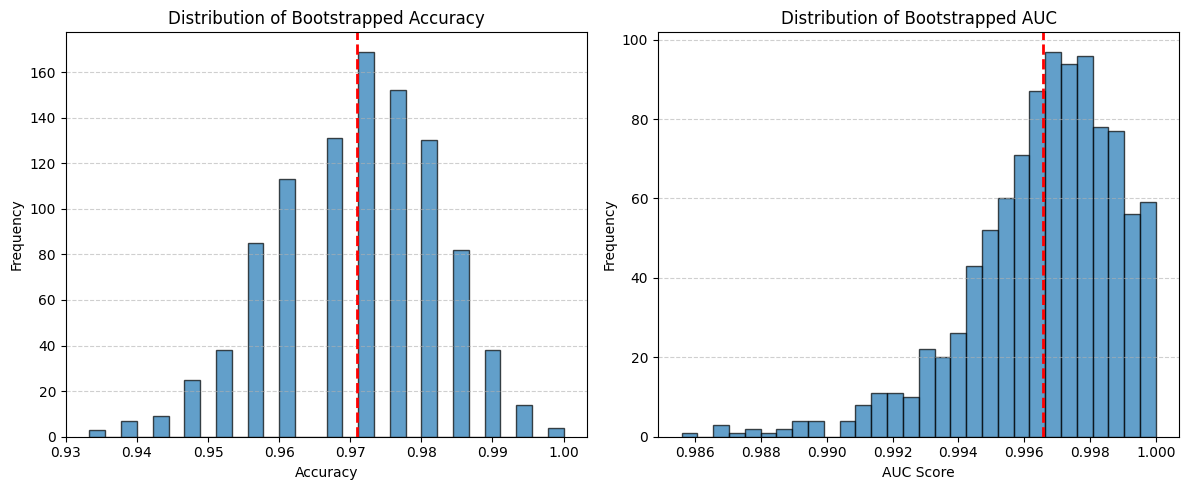

In [25]:
# Generate bootstrapped accuracy and AUC scores
n_bootstrap = 1000
bootstrapped_accuracies = []
bootstrapped_aucs = []

rng = np.random.default_rng(seed=42)

for _ in range(n_bootstrap):
    indices = rng.integers(0, len(y_test), len(y_test))
    y_true_bootstrap = y_test.to_numpy()[indices]
    y_pred_bootstrap = y_pred[indices]
    y_prob_bootstrap = y_prob[indices]

    bootstrapped_accuracies.append(accuracy_score(y_true_bootstrap, y_pred_bootstrap))
    bootstrapped_aucs.append(roc_auc_score(y_true_bootstrap, y_prob_bootstrap))

# Compute mean values
mean_accuracy = np.mean(bootstrapped_accuracies)
mean_auc = np.mean(bootstrapped_aucs)

# Plot accuracy distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(bootstrapped_accuracies, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(mean_accuracy, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Distribution of Bootstrapped Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Plot AUC distribution
plt.subplot(1, 2, 2)
plt.hist(bootstrapped_aucs, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(mean_auc, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("AUC Score")
plt.ylabel("Frequency")
plt.title("Distribution of Bootstrapped AUC")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show plots
plt.tight_layout()
plt.show()

The results obtained using bootstrapping provide more precise confidence intervals compared to standard statistical methods. Bootstrapping directly uses resampling to capture variability in the data, allowing for an empirical estimation of the distribution of accuracy and AUC. This method accounts for the specific characteristics of the dataset, providing confidence intervals that reflect the actual data distribution.

In contrast, traditional methods rely on theoretical assumptions that may not fully capture the complexity or variability present in real-world data. In this case, the bootstrapped confidence intervals are both narrow and centered around the observed mean values, demonstrating high stability and consistency of the model's performance.

Therefore, bootstrapping offers more reliable confidence intervals, particularly when validating model performance metrics like accuracy and AUC.

10. Using your cross-validation results, compute a 95% confidence interval for each coefficient in the model. Which feature(s) might you remove based on this?

In [28]:
# Access logistic regression coefficients from the trained pipeline
log_reg = pipeline.named_steps['classifier']  # LogisticRegression model
scaler = pipeline.named_steps['scaler']       # StandardScaler for scaling

# Scale the training data to get consistent coefficients
X_train_scaled = scaler.transform(X_train)

# Perform bootstrapping for coefficients
n_bootstrap = 1000
coefficients = []

rng = np.random.default_rng(seed=42)

for _ in range(n_bootstrap):
    # Resample with replacement
    indices = rng.integers(0, len(X_train_scaled), len(X_train_scaled))
    X_resampled = X_train_scaled[indices]
    y_resampled = y_train.to_numpy()[indices]

    # Fit logistic regression on the resampled data
    log_reg.fit(X_resampled, y_resampled)
    coefficients.append(log_reg.coef_[0])

# Convert bootstrapped coefficients to a NumPy array
coefficients = np.array(coefficients)

# Compute confidence intervals for each feature
ci_lower = np.percentile(coefficients, 2.5, axis=0)
ci_upper = np.percentile(coefficients, 97.5, axis=0)

# Display results
for idx, feature_name in enumerate(X.columns):
    print(f"{feature_name}: 95% CI = ({ci_lower[idx]:.4f}, {ci_upper[idx]:.4f})")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_

Cl.thickness: 95% CI = (0.4095, 3.4629)
Cell.size: 95% CI = (-1.2291, 3.4027)
Cell.shape: 95% CI = (-0.4789, 2.7501)
Marg.adhesion: 95% CI = (-0.3910, 2.2836)
Epith.c.size: 95% CI = (-1.0273, 1.4691)
Bare.nuclei: 95% CI = (0.6286, 4.1721)
Bl.cromatin: 95% CI = (-0.8300, 2.8020)
Normal.nucleoli: 95% CI = (-0.3995, 1.7558)
Mitoses: 95% CI = (-0.3977, 3.1008)
Age: 95% CI = (-0.2636, 2.0281)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Based on the 95% confidence intervals for the logistic regression coefficients, several features may be considered for removal as their intervals include zero, indicating they may not have a statistically significant contribution to the model. These features include `Cell.size`, `Cell.shape`, `Marg.adhesion`, `Epith.c.size`, `Bl.cromatin`, `Normal.nucleoli`, `Mitoses`, and `Age`. In contrast, features such as `Cl.thickness` and `Bare.nuclei` have confidence intervals entirely above zero, suggesting they are strong predictors of the outcome and should be retained. Removing the non-significant features could simplify the model without substantially affecting its performance while improving its interpretability.

11. Fit your logistic regression model like before but remove the feature(s) you indentified in Q10. Plot the ROC curve of the model over the test set and annotate it with the AUC of the model.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


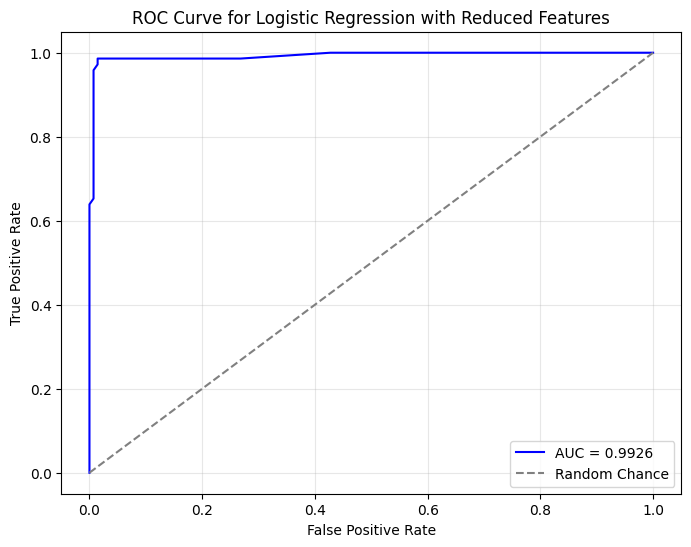

In [29]:
# Remove non-significant features identified in Q10
significant_features = ['Cl.thickness', 'Bare.nuclei']  # Features with confidence intervals entirely above zero
X_train_reduced = X_train[significant_features]
X_test_reduced = X_test[significant_features]

# Refit the logistic regression model with the reduced feature set
pipeline_reduced = Pipeline([
    ('scaler', StandardScaler()),  # Standardize predictors
    ('classifier', LogisticRegression(
        solver='lbfgs',     # Optimization algorithm
        penalty=None,       # No regularization
        max_iter=10000,     # Ensure convergence
        verbose=1,          # Display training progress
        random_state=0,     # Reproducibility
        n_jobs=-1           # Use all available CPU cores
    ))
])

pipeline_reduced.fit(X_train_reduced, y_train)

# Predict probabilities for the test set
y_prob_reduced = pipeline_reduced.predict_proba(X_test_reduced)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob_reduced)
auc_score_reduced = roc_auc_score(y_test, y_prob_reduced)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score_reduced:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression with Reduced Features")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

12. Calculate the uncertainty for the prediction of the first testing patient.  Plot a histogram of the different predictions. Give the plot a title and axes labels. Add a red vertical line representing the mean of the predictions.

Hint: If you need to stack a list of arrays, you can use [np.hstack(list)](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

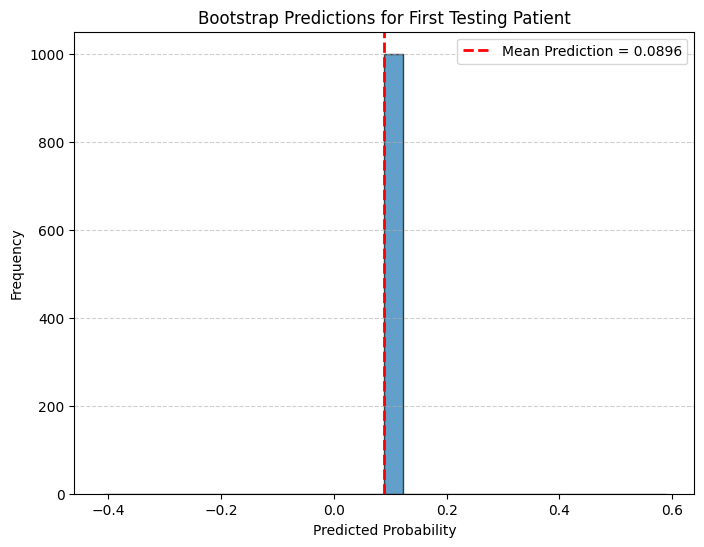

In [38]:
# Bootstrapping predictions for the first testing patient
n_bootstrap = 1000
first_patient_preds = []

rng = np.random.default_rng(seed=42)

# Convert Polars DataFrame to NumPy for indexing purposes
X_test_reduced_np = X_test_reduced.to_numpy()
y_test_np = y_test.to_numpy()

for _ in range(n_bootstrap):
    # Resample with replacement
    indices = rng.integers(0, len(X_test_reduced_np), len(X_test_reduced_np))
    X_resampled = X_test_reduced_np[indices]
    y_resampled = y_test_np[indices]

    # Refit logistic regression model
    pipeline_reduced.fit(X_train_reduced, y_train)

    # Predict probability for the first testing patient
    first_patient_prob = pipeline_reduced.predict_proba(X_test_reduced_np[0].reshape(1, -1))[0, 1]
    first_patient_preds.append(first_patient_prob)

# Convert to NumPy array
first_patient_preds = np.array(first_patient_preds)

# Calculate mean prediction
mean_prediction = np.mean(first_patient_preds)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(first_patient_preds, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(mean_prediction, color='red', linestyle='dashed', linewidth=2, label=f"Mean Prediction = {mean_prediction:.4f}")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Bootstrap Predictions for First Testing Patient")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()